In this notebook, I created a model to predict the sale prices of houses in Ames, Iowa using the dataset from Kaggle.com. Below is the link to the dataset
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


First, I imported the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
import joblib
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import norm
from scipy.stats import probplot
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

np.random.seed(42)

import warnings
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
#pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# 1. Exploratory Data Analysis

### 1.A. Preview dataset and create test set

In [3]:
house = pd.read_csv(os.path.join('HousePrices','train.csv'))
house

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,...,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,...,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,...,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,...,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,...,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,...,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,...,4,2010,WD,Normal,142125


There are 1460 samples and 79 variables (excluding Id and SalePrice)

In [4]:
house.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

There are 43 categorical features, 36 numerical features (excluding Id and SalePrice)

In [5]:
house['SalePrice'].describe() # summary statistics of dependent variable

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
# Create a test set
x = house.drop(['SalePrice', 'Id'],axis=1)
y = house['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle = True)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

I created a test set and set it aside. This set will be used at the end to compute my model's generalization error. From here on, I worked only with the train set

In [7]:
# Create the training set with x and y-values
train = pd.concat([x_train, y_train], axis=1) # combining the features and SalePrice together

### 1.B. Check for missing values

In [8]:
def check_na(data):
    total = data.isnull().sum() # total missing values of each column
    percent = total/len(data)*100 # compute percent missing values of each column
    dtype = data.dtypes # data type

    nans = pd.concat([total, percent, dtype], axis=1, keys=['Total', 'Percent', 'Dtype'])
    nans = nans.sort_values(by = ['Percent'], ascending = False)

    num_missing_variable = data.isnull().any().sum() # counting the number of variables with missing values
    
    return nans.head(num_missing_variable) # print out the information only for the variables with missing values  

In [9]:
check_na(train)

,Total,Percent,Dtype
PoolQC,1163,99.571918,object
MiscFeature,1124,96.232877,object
Alley,1097,93.921233,object
Fence,954,81.678082,object
FireplaceQu,548,46.917808,object
LotFrontage,209,17.893836,float64
GarageYrBlt,61,5.222603,float64
GarageCond,61,5.222603,object
GarageType,61,5.222603,object
GarageFinish,61,5.222603,object


### 1.C. Plots 

I created scatter plots to look at the relationship between SalePrice and numerical features <br>
The scatter plots were sorted based on correlation coefficient, in descending order

In [10]:
def plot_scatter(data):
    corr = data.corr() 
    corr_desc = pd.DataFrame(corr['SalePrice'].sort_values(ascending = False))

    corr_desc.drop(['SalePrice'],axis=0, inplace = True) # dropping the SalePrice index label. Needed for the next line of code

    # needed for FacetGrid (data has to be in long format)
    long_df = pd.melt(data, id_vars = ['SalePrice'], value_vars = list(corr_desc.index),  #Note: corr_desc.index gets the NAMES of numerical features correlated with SalePrice (high to low correlation value)
                      var_name = 'Feature', value_name = 'Values')

    subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) # sharex=True means all x-axis have same scale
    subplots.map(plt.scatter, "Values", "SalePrice", alpha=0.2)

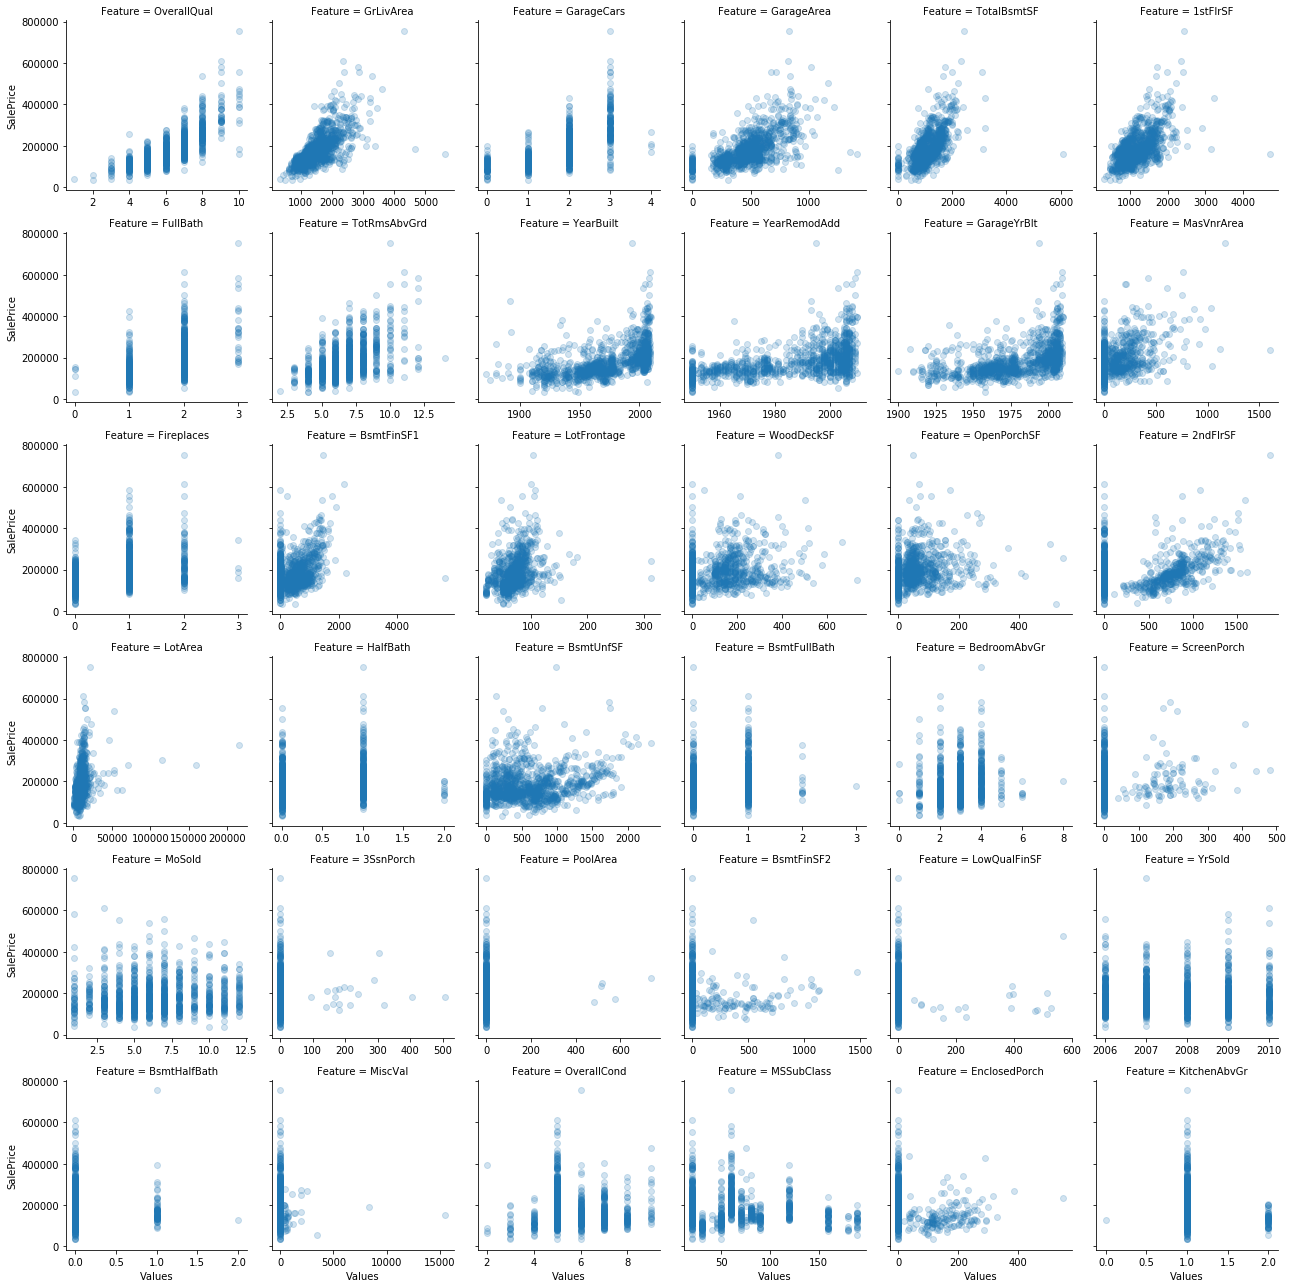

In [11]:
plot_scatter(train)

I will convert MSSubClass and MoSold to categorical variables. It doesnt make sense for them to be numerical variables.

I will create new features to better represent the year information (YrSold, YearBuilt, GarageYrBuilt, YearRemodAdd)

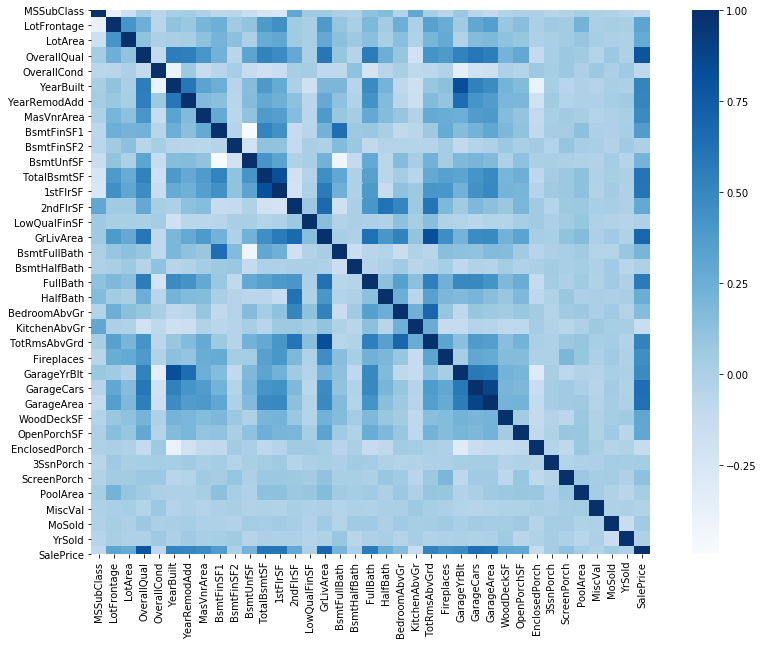

In [12]:
corrmat = train.corr()
plt.figure(figsize=(15, 10)) #height, width
sns.heatmap(corrmat, cmap = 'Blues', square = True, annot=False, fmt='.2f',annot_kws={'size': 8}, cbar= True)

Next, I created boxplots to visualize categorical variables <br>

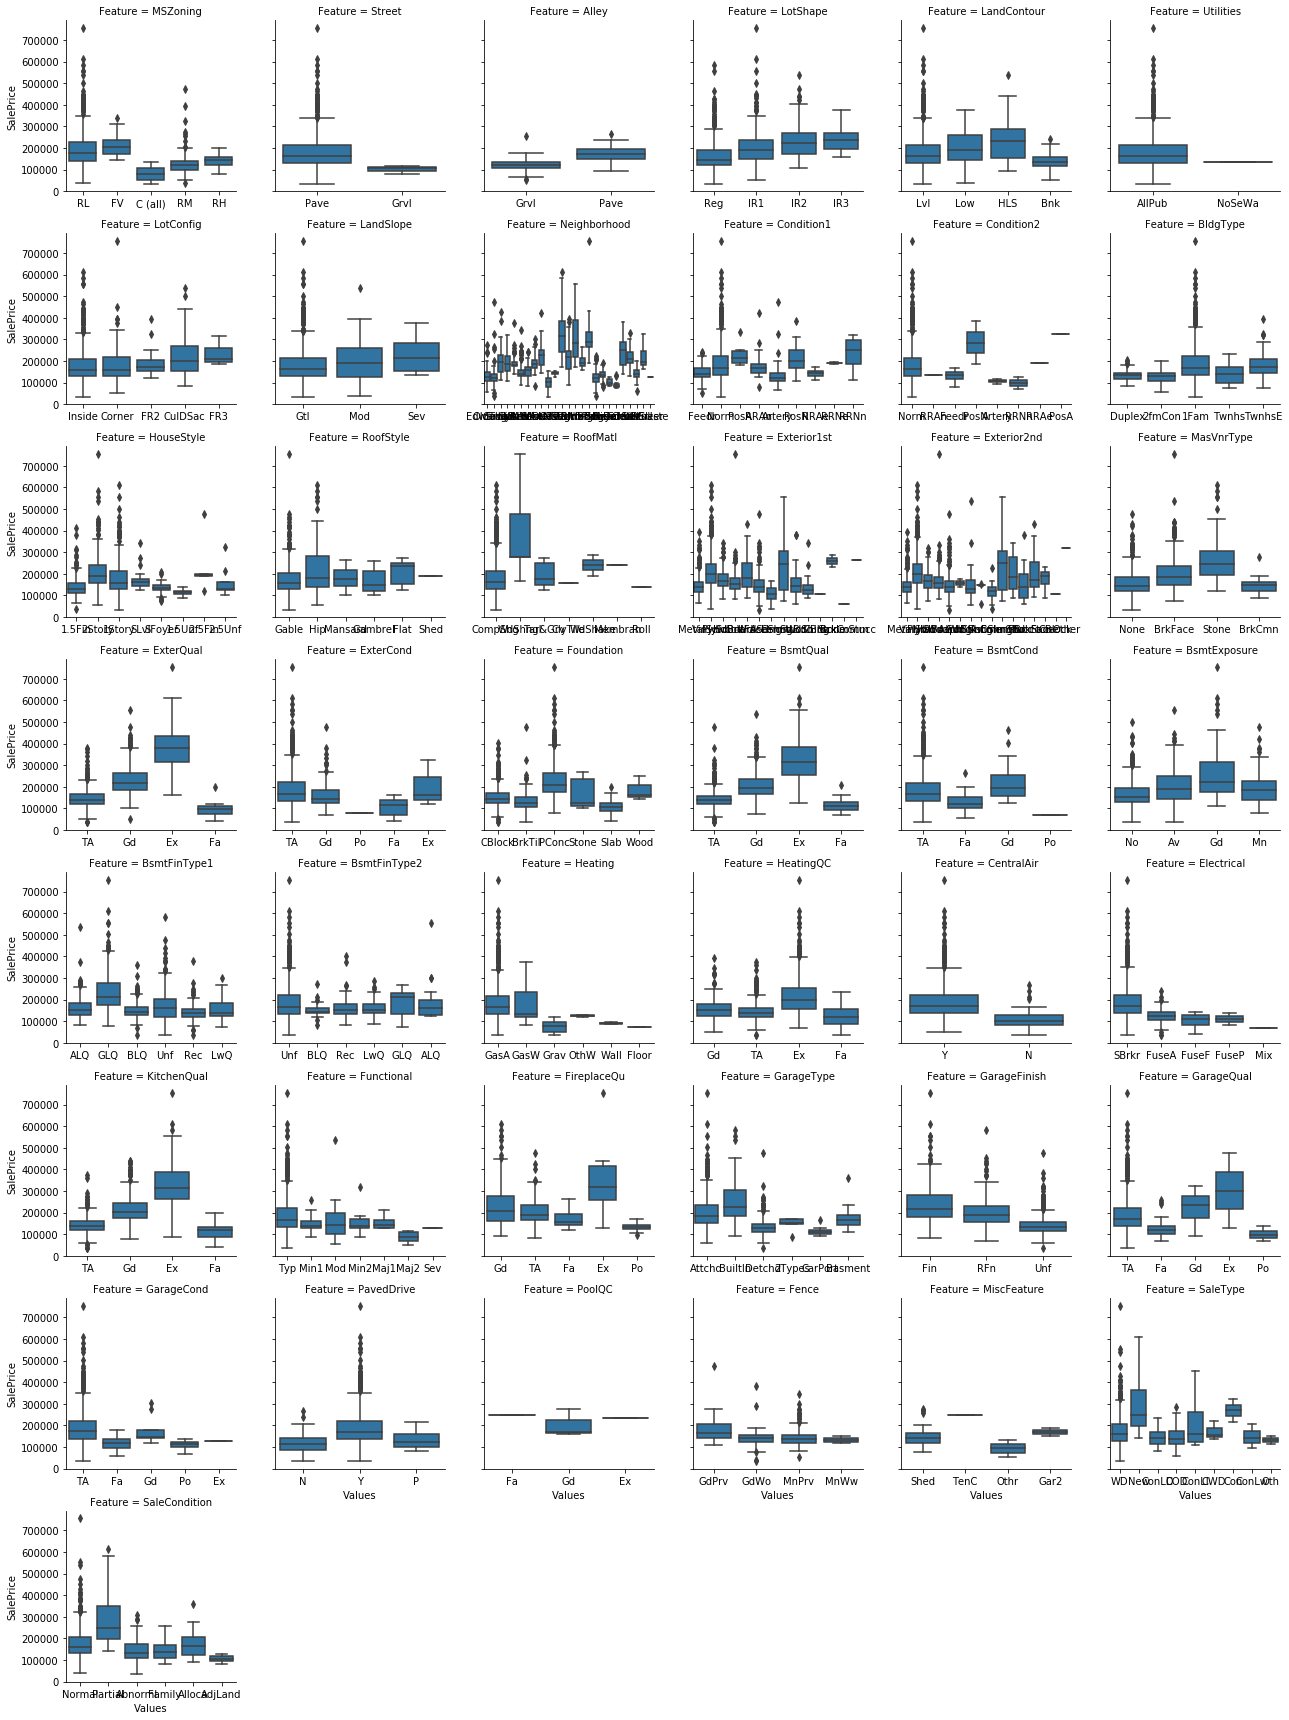

In [13]:
categorical = train.select_dtypes('object') 

long_df = pd.melt(train, id_vars = ['SalePrice'], value_vars = list(categorical),  #Note: corr_asc.index gets the NAMES of numerical features correlated with SalePrice (high to low correlation value)
                  var_name = 'Feature', value_name = 'Values')

subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) # sharex=True means all x-axis have same scale
subplots.map(sns.boxplot, "Values", "SalePrice")

I will drop categorical levels with too few observations in them in an effort to cut down the number of unnecessary features post-get_dummies

# 2. Data Transformation

In [14]:
x_train_tr = x_train.copy()

### 2.A. Create new features

In [15]:
def new_features(X):
    X['AgeBuilt'] = X['YrSold'] - X['YearBuilt'] #age of house since it was built
    X['AgeGarageBlt'] = X['YrSold'] - X['GarageYrBlt'] #age of garage since it was built
    X['AgeRemodeled'] = X['YrSold'] - X['YearRemodAdd'] #age of house since it was remodeled
    
    return X

In [16]:
x_train_tr = new_features(x_train_tr)

In [17]:
drop_var1 = ['YrSold','YearBuilt','GarageYrBlt','YearRemodAdd']
x_train_tr.drop(drop_var1, axis=1, inplace = True)

### 2.B. Convert numerical to categorical features

In [18]:
def num_to_cat(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
    return X

In [19]:
x_train_tr = num_to_cat(x_train_tr)

### 2.C. Handle missing values

Based on the description on Kaggle, some of the categorical variables have 'None' as one of the levels, which is abbreviated to NA in their dataset. 

When the dataset is read in Python, NA will be interepreted as missing values (i.e. NaN). Therefore, the missing values in these categorical variable should be correctly labelled as 'None'.

In [20]:
def nan_to_none(X): 
    
    features_with_none_level = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
                                'GarageType', 'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
    
    for col_name in features_with_none_level:    
        X[col_name] = X[col_name].fillna('None')
        
    return X

In [21]:
# I looked at the missing values in train, test, and submission set and decided what to do with them based on my logic
def handle_missing_values(X): 

    nan_to_none(X)

    for fill_0 in ['MasVnrArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
                   'GarageArea', 'BsmtUnfSF']:
        X[fill_0] = X[fill_0].fillna(0)
        
    for num_col in list(X.select_dtypes(exclude='object')):
        X[num_col] = X[num_col].fillna(x_train_tr[num_col].median())

    for categ_col in list(X.select_dtypes(include='object')):
        X[categ_col] = X[categ_col].fillna(x_train_tr[categ_col].mode()[0])
        
    return X

In [22]:
x_train_tr = handle_missing_values(x_train_tr)

In [23]:
check_na(x_train_tr) # no more missing values

,Total,Percent,Dtype


### 2.D. Ordinal encoding

I also encoded some of the categorical variables into ordinal variables. <br>

For example: The variable 'ExterQual' has 5 levels: Excellent, Good, Average/Typical, Fair, Poor. <br>
I will encode the levels as 0 for Poor, 1 for Fair, 2 for Average/Typical, and so on. <br>

By encoding them into ordinal values, it allows me to plot them as scatter plots and better understand their correlation with SalePrice

In [24]:
x_train_encode = x_train_tr.copy() # I'm creating a copy because when later on when imputing missing values for test and submission set, I need to impute the mode and median based on x_train_tr which is not ordinal-encoded and robust-scaled

In [25]:
def ordinal_encoding(X):
    X['Functional'] = X['Functional'].map({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0})
    X['Alley'] = X['Alley'].map({'Pave':2,'Grvl':1,'None':0})
    X['Street'] = X['Street'].map({'Pave':1,'Grvl':0})
    X['LotShape'] = X['LotShape'].map({'Reg':3, 'IR1':2,'IR2':1,'IR3':0})
    X['Utilities'] = X['Utilities'].map({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':1}) 
    X['LandSlope'] = X['LandSlope'].map({'Gtl':2,'Mod':1,'Sev':0})
    X['ExterQual'] = X['ExterQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['ExterCond'] = X['ExterCond'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['BsmtQual'] = X['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['BsmtCond'] = X['BsmtCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['BsmtExposure'] = X['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0})
    X['BsmtFinType1'] = X['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
    X['BsmtFinType2'] = X['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
    X['HeatingQC'] = X['HeatingQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['CentralAir'] = X['CentralAir'].map({'N':0,'Y':1})
    X['KitchenQual'] = X['KitchenQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    X['FireplaceQu'] = X['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['GarageFinish'] = X['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0})
    X['GarageQual'] = X['GarageQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['GarageCond'] = X['GarageCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
    X['PavedDrive'] = X['PavedDrive'].map({'Y':2,'P':1,'N':0})
    X['PoolQC'] = X['PoolQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
    
    return X

In [26]:
x_train_encode = ordinal_encoding(x_train_encode)

### 2.E. Feature scaling and feature selection for numerical variables

In [27]:
x_train_scaled = x_train_encode.copy()

In [28]:
# Feature scaling
fs = RobustScaler() 
cols_scaled = list(x_train_scaled.select_dtypes(exclude='object')) #get the numerical columns to be scaled
x_train_scaled[cols_scaled] = fs.fit_transform(x_train_scaled[cols_scaled]) 

Plot the transformed numerical features against saleprice

In [29]:
train_tr = pd.concat([x_train_scaled,y_train], axis=1)

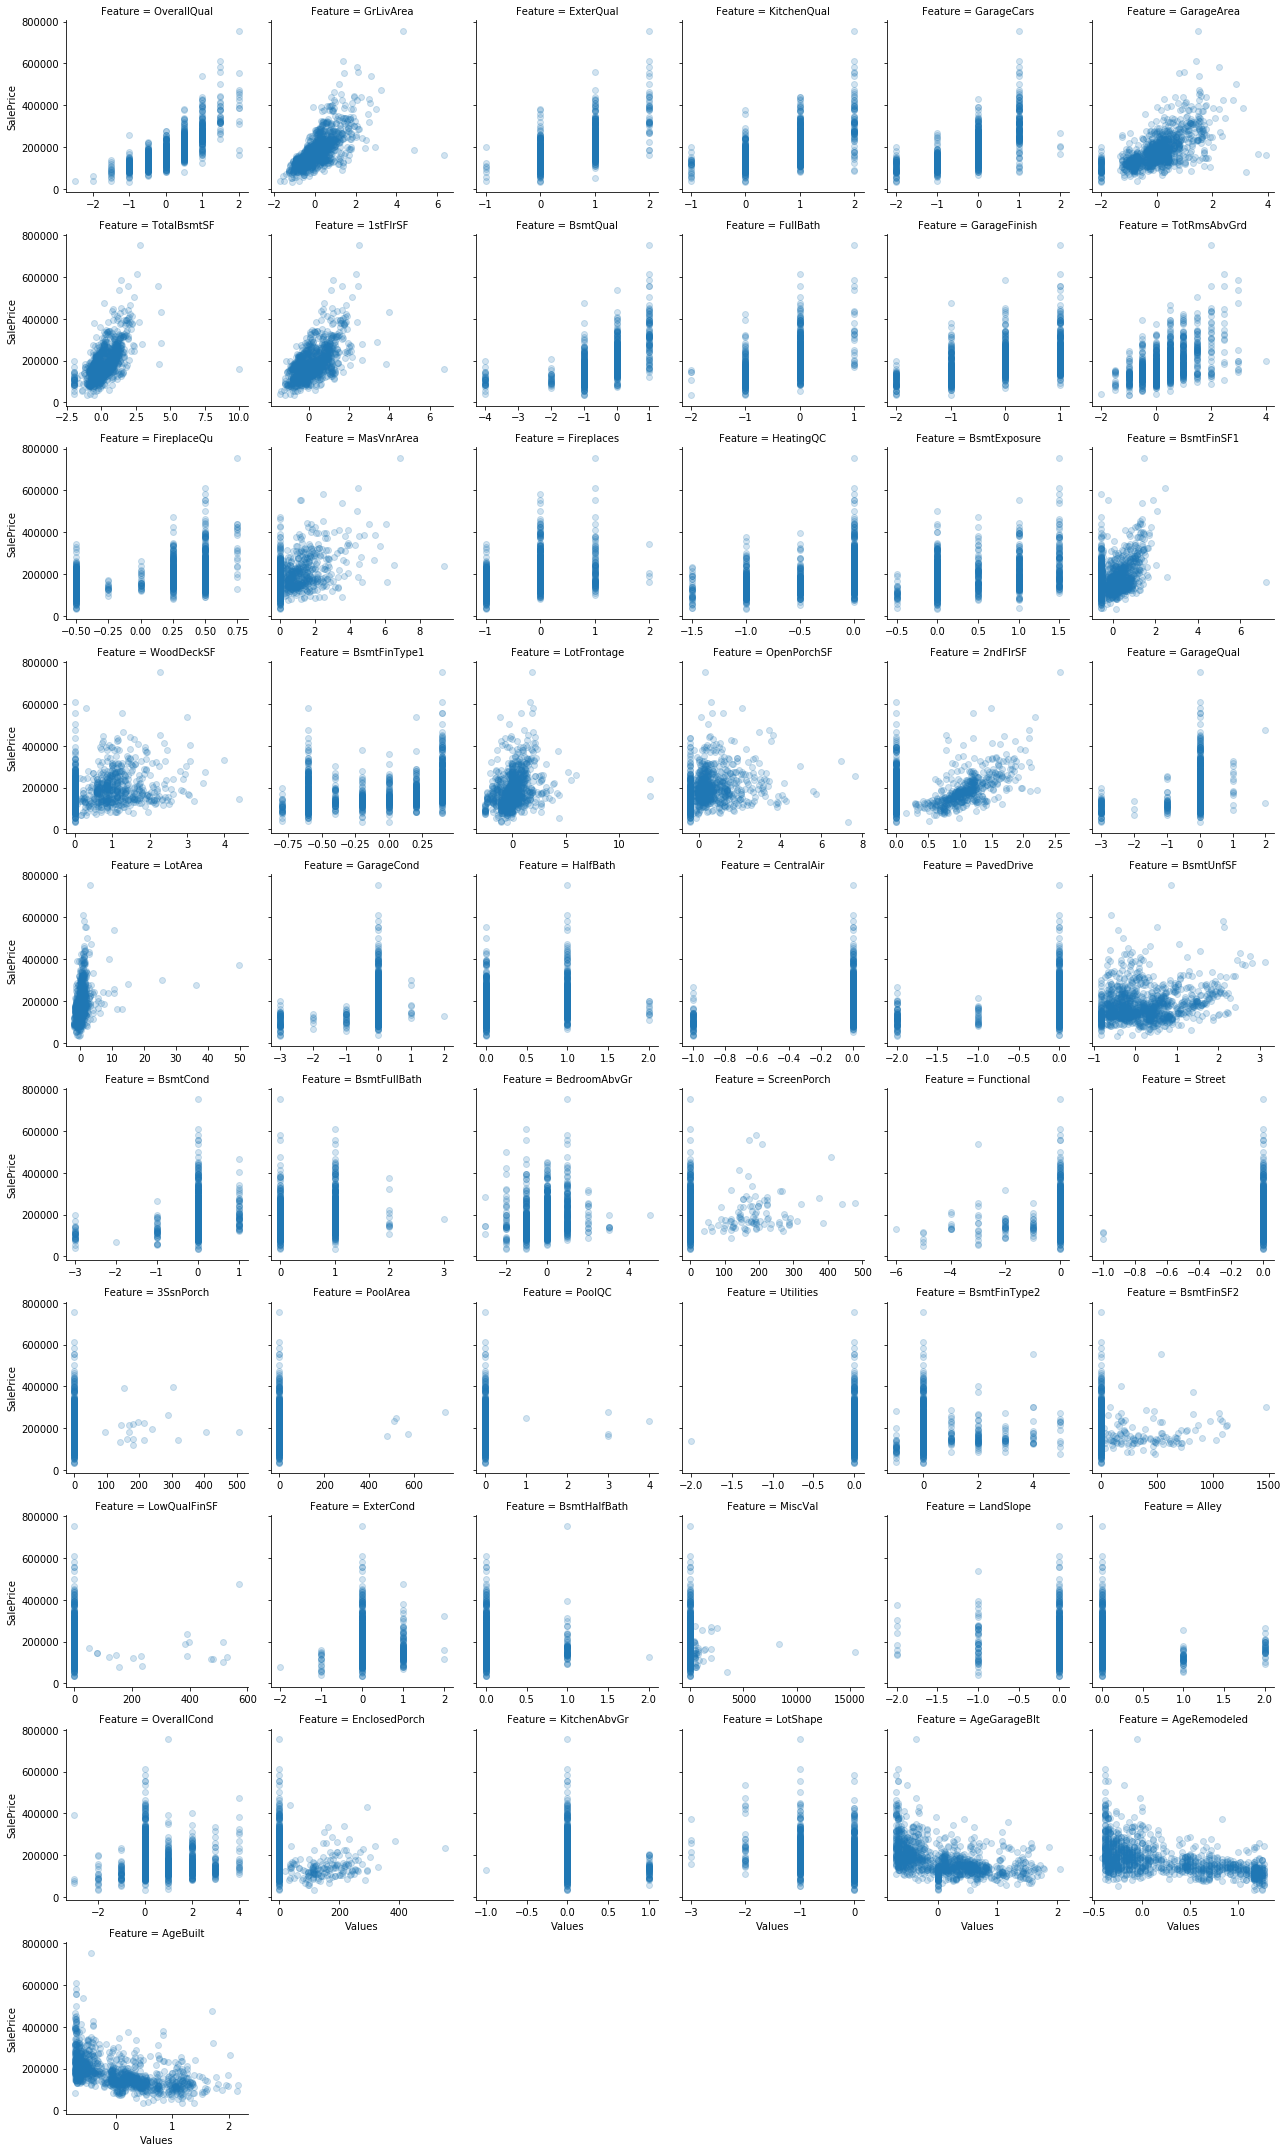

In [30]:
plot_scatter(train_tr) #plot transformed and scaled numerical values

In [31]:
num_features_keep=['OverallQual','GrLivArea','ExterQual','KitchenQual','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF', 
                   'BsmtQual','FullBath','GarageFinish','TotRmsAbvGrd','LotFrontage','AgeGarageBlt','AgeRemodeled','AgeBuilt',
                   'SalePrice']

all_num_features = train_tr.select_dtypes(exclude='object')

drop_var2 =  set(all_num_features) - set(num_features_keep) 
train_tr.drop (drop_var2, axis=1, inplace=True)

I plotted a heatmap to visualize collinearity (features that are correlated with each other) <br>
The features included in this matrix are the ones that I believe have a clear relationship with SalePrice <br>

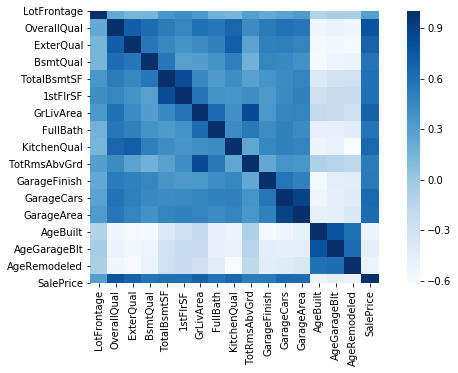

In [32]:
corrmat = train_tr.corr()
plt.figure(figsize=(10,5)) #height, width
sns.heatmap(corrmat, cmap = 'Blues', square = True, annot=False, fmt='.2f',annot_kws={'size': 8})

Based on the heatmap, it seems like there is high correlation between:
- GarageArea and GarageCars
- TotalBsmtSF and BsmtQual
- GrLivArea and TotRmsAbvGrd
- KitchenQual and ExterQual
- AgeGarageBlt and AgeBuilt
- AgeRemodeled and AgeGarageBlt
- AgeBuilt and AgeRemodeled

In [33]:
drop_var3 = ['GarageCars','BsmtQual','TotRmsAbvGrd','KitchenQual','AgeGarageBlt','AgeRemodeled']

In [34]:
train_tr.drop (drop_var3, axis=1, inplace=True)

### 2.F. Dummy coding

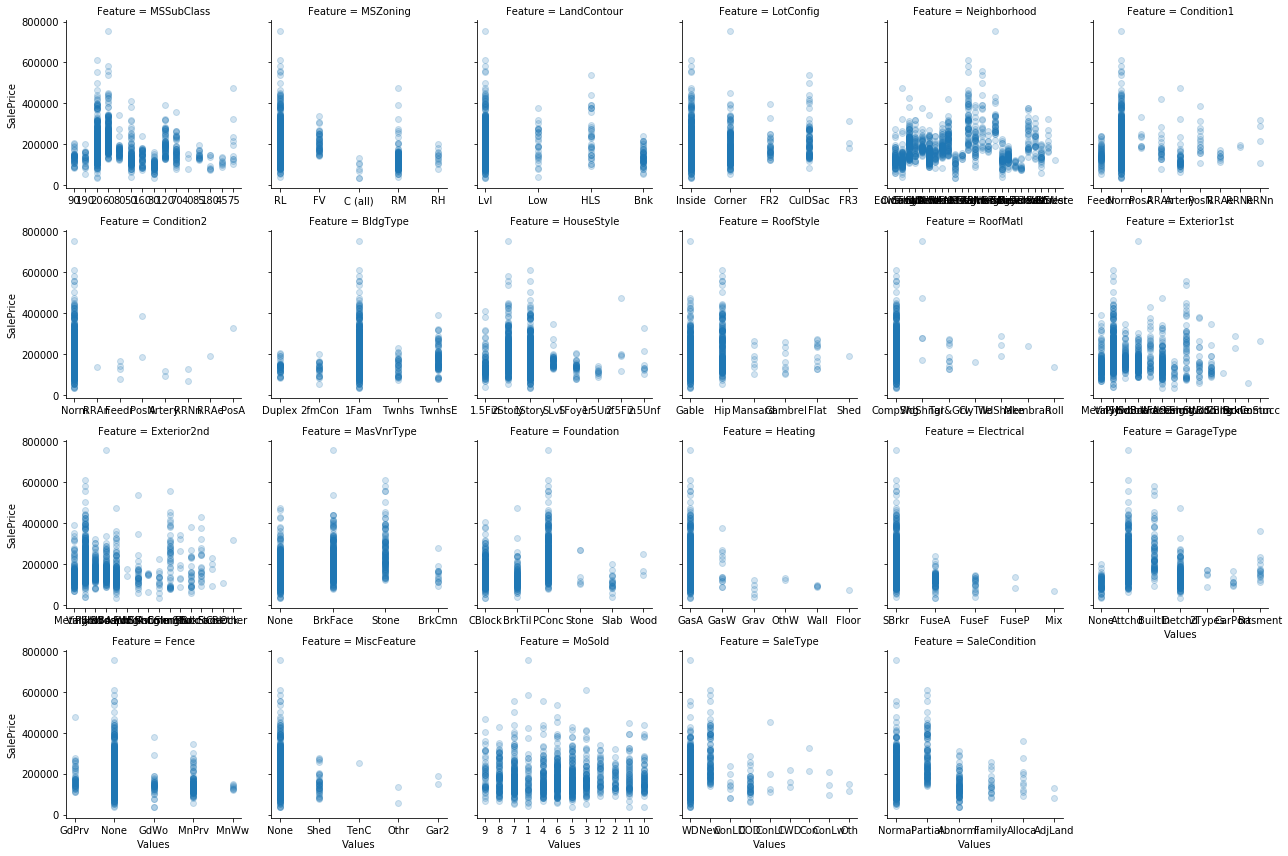

In [35]:
categorical = train_tr.select_dtypes('object') 

long_df = pd.melt(train_tr, id_vars = ['SalePrice'], value_vars = list(categorical),  #Note: corr_asc.index gets the NAMES of numerical features correlated with SalePrice (high to low correlation value)
                  var_name = 'Feature', value_name = 'Values')

subplots = sns.FacetGrid(long_df, col="Feature", col_wrap = 6, sharex = False) # sharex=True means all x-axis have same scale
subplots.map(plt.scatter, "Values", "SalePrice", alpha = 0.2)

In [36]:
drop_var4 = ['MoSold', 'Fence', 'LotConfig', 'RoofStyle','BldgType', 'Condition2', 'RoofMatl', 'Heating','MiscFeature',
             'Condition1','Electrical','Exterior2nd']

In [37]:
train_tr.drop (drop_var4, axis=1, inplace=True)

In [38]:
train_tr = pd.get_dummies(train_tr)

In [39]:
pd.options.display.max_rows = 10
train_tr

,LotFrontage,OverallQual,ExterQual,TotalBsmtSF,1stFlrSF,...,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.105263,-0.5,0.0,0.518119,0.324906,...,0,0,0,1,0
1,-0.473684,-1.0,0.0,-1.973555,-0.757491,...,0,0,0,1,0
2,-0.210526,0.5,1.0,0.592556,0.396067,...,0,0,0,0,1
3,0.684211,0.5,1.0,-0.392752,0.143258,...,0,0,0,1,0
4,-0.368421,0.0,0.0,-0.330069,-0.439139,...,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1163,0.473684,0.0,0.0,0.110676,0.470974,...,0,0,0,1,0
1164,0.578947,-0.5,0.0,0.095005,-0.066479,...,0,0,0,1,0
1165,-0.473684,0.0,0.0,-0.633692,-0.609551,...,0,0,0,1,0
1166,-2.526316,0.0,0.0,-1.027424,-1.152622,...,0,0,0,1,0


# 3. Train Models

In [40]:
x_train_ft = train_tr.drop('SalePrice',axis=1) #ft = fully transformed
y_train = train_tr['SalePrice']

In [41]:
def train_error(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt (mean_squared_error(y, y_pred))
    print ('Train RMSE:', int(rmse))  

In [42]:
def cv_error(model, X, y): 
    scores = cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 10) 
    rmse = np.sqrt(-scores) 
    print ('Mean CV RMSE:', int(rmse.mean()), '±', int(rmse.std()))  

### LASSO Regression

In [43]:
lasso = LassoCV(alphas=[0.01, 0.1, 1, 10, 100, 1000] , cv = 10, random_state=42)
lasso.fit(x_train_ft, y_train)
train_error (lasso, x_train_ft, y_train)
cv_error(lasso, x_train_ft, y_train)

Train RMSE: 31829
Mean CV RMSE: 34702 ± 8677


### Random Forest 

In [44]:
forest = RandomForestRegressor(random_state=42, n_estimators = 1100, max_features = 0.3)
forest.fit(x_train_ft, y_train)
train_error(forest, x_train_ft, y_train)
cv_error(forest, x_train_ft, y_train)

Train RMSE: 11587
Mean CV RMSE: 31275 ± 6760


### XGBoost 

In [45]:
xg = XGBRegressor(random_state=42, silent = True, n_estimators = 4500, learning_rate = 0.01, max_depth = 2)
xg.fit(x_train_ft, y_train)
train_error (xg,x_train_ft, y_train)
cv_error(xg,x_train_ft, y_train)

Train RMSE: 17064
Mean CV RMSE: 30991 ± 6885


# 4. Evaluate Model on Test Set

In [46]:
x_test_ft = x_test.copy()

### 4.A. Transform test set

In [47]:
def full_transform(X):
    X = new_features(X)
    X.drop(drop_var1, axis=1, inplace = True) # drop 'Year' features
    X = num_to_cat(X)
    X = handle_missing_values(X)
    X = ordinal_encoding(X)
    
    numerical_columns = list(X.select_dtypes(exclude='object'))
    X[numerical_columns] = fs.transform(X[numerical_columns])
    
    X.drop(drop_var2, axis=1, inplace=True) # drop unnecessary numerical features
    X.drop(drop_var3, axis=1, inplace=True) # drop correlated numerical features
    X.drop(drop_var4, axis=1, inplace=True) # drop unnecessary categorical features
    
    X = pd.get_dummies(X)
    
    # Below is for dropping the new dummy-coded features that might appear in the test set
    missing_cols = set(x_train_ft.columns) - set(X.columns) # Find cols that exist in train but not in test

    # Add the missing column in test set and set it equal to 0
    for col in missing_cols: 
        X[col] = 0

    X = X[x_train_ft.columns] # Make the column order in test set same as the column order in training set

    return X

In [48]:
x_test_ft = full_transform(x_test_ft)

### 4.B. Evaluate test set

In [49]:
def eval_test (model, X, y):
    y_pred = model.predict(X)

    msle = mean_squared_log_error(y, y_pred)
    rmsle = np.sqrt(msle)
    print ('RMSLE:', rmsle)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    print ('RMSE:', int(rmse))

In [50]:
eval_test (lasso, x_test_ft, y_test)

RMSLE: 0.18415849258007272
RMSE: 34614


In [51]:
eval_test (xg, x_test_ft, y_test)

RMSLE: 0.14356857737693907
RMSE: 23821


In [52]:
eval_test (forest, x_test_ft, y_test)

RMSLE: 0.1545950430580656
RMSE: 29534


# 5. Submission set

In [53]:
submit = pd.read_csv("HousePrices/test.csv")
submit_id = submit['Id']  # will be needed when writing to file at the end
submit = submit.drop(['Id'],axis=1)

In [54]:
submit_ft = full_transform(submit) # transform the dataset

In [55]:
y = xg.predict(submit_ft) # make predictions

In [56]:
# Create dataframe and write to file

submit_file = pd.DataFrame({'Id': submit_id, 'SalePrice': y})

submit_file.to_csv('houseprices_pred5.csv', index=False)

# References and acknowledgements

Some of the concepts in this notebook was inspired from the works of Aurelien Geron (author of Hands-On Machine Learning with Scikit-learn and Tensorflow), Lavanya Shukla (https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition), and Pedro Marcelino (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)